In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sklearn.utils import shuffle
benign_data = pd.read_csv("/content/drive/MyDrive/Thesis_Projects/URL_detection/Benign.csv")

malicious_data = pd.read_csv("/content/drive/MyDrive/Thesis_Projects/URL_detection/Malicious.csv")

df1 = pd.DataFrame(benign_data)
df2 = pd.DataFrame(malicious_data)

x = df1.sample(25000)
y = df2.sample(25000)

data = pd.concat([x,y], axis=0)
data = shuffle(data)
data

,url,label
25807,sochi2014realty.ru/wp-content/plugins/wp_comm/...,1
7483,www.sundance-communications.com/cgi-bin/ultima...,0
3619,members.shaw.ca/pisces45/,0
23031,www.websupergoo.com/imageeffects-1.htm,0
22780,www.austinpcc.org/scripts/tinymce/jscripts/tin...,1
...,...,...
25767,www.allegrologowanie.hostoi.com/allegro_wAYGDE...,1
4223,www.balcan.co.uk/lamp-crushers/,0
33415,users.skynet.be/smellenbergh/,0
43930,www.superliminal.com/cube/cube.htm,0


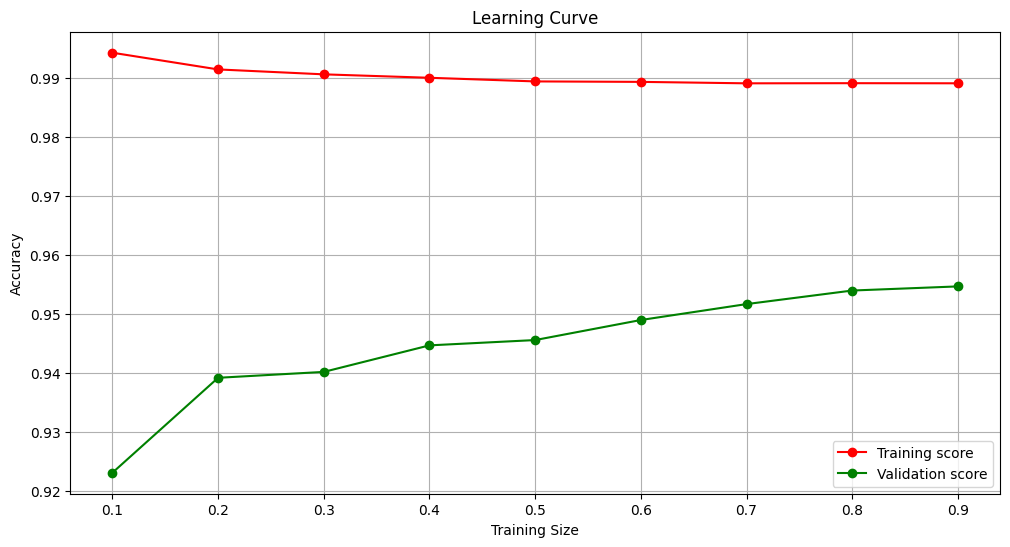

Validation Classification Report:
              precision    recall  f1-score   support

           0     0.9457    0.9623    0.9539      4902
           1     0.9631    0.9468    0.9549      5098

    accuracy                         0.9544     10000
   macro avg     0.9544    0.9546    0.9544     10000
weighted avg     0.9545    0.9544    0.9544     10000

Test Classification Report:
              precision    recall  f1-score   support

           0     0.9536    0.9603    0.9570      4991
           1     0.9602    0.9535    0.9568      5009

    accuracy                         0.9569     10000
   macro avg     0.9569    0.9569    0.9569     10000
weighted avg     0.9569    0.9569    0.9569     10000



In [4]:
# Assuming the dataset has columns 'text' and 'label'
texts = data['url'].values
labels = data['label'].values

# Split the data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=2018)

# Further split the training data into 75% training and 25% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2018)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2018)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=2018))
]

# Define the meta-model
meta_model = LogisticRegression(random_state=2018)

# Create the StackingClassifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the model and plot the learning curve
def plot_learning_curve(model, X_train, y_train, X_val, y_val):
    train_sizes = np.linspace(0.1, 0.9, 9)  # Adjusted training sizes
    train_scores = []
    val_scores = []

    for train_size in train_sizes:
        X_train_part, _, y_train_part, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=2018)
        model.fit(X_train_part, y_train_part)
        train_scores.append(accuracy_score(y_train_part, model.predict(X_train_part)))
        val_scores.append(accuracy_score(y_val, model.predict(X_val)))

    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores, 'o-', color="g", label="Validation score")
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curve before fitting the final model
plot_learning_curve(stacked_model, X_train_tfidf, y_train, X_val_tfidf, y_val)

# Fit the final model
stacked_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
val_predictions = stacked_model.predict(X_val_tfidf)

# Evaluate the model on the validation set
print("Validation Classification Report:")
print(classification_report(y_val, val_predictions, digits=4))

# Make predictions on the test set
test_predictions = stacked_model.predict(X_test_tfidf)

# Evaluate the model on the test set
print("Test Classification Report:")
print(classification_report(y_test, test_predictions, digits=4))